In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from koe.model_utils import get_or_error
from koe.models import Database
from koe.sequence_utils import get_sequences
from koe.storage_utils import get_sids_tids
from root.models import User
from koe.cluster_analysis_utils import SimpleNameMerger, NameMerger, get_syllable_labels
from koe.sequence_utils import songs_to_syl_seqs
from koe.sequence_utils import calc_class_ajacency, calc_class_dist_by_adjacency

from nltk import ngrams

from koe.models import Segment, AudioFile
from root.models import ExtraAttr, ExtraAttrValue
from collections import Counter

import os
from django.conf import settings
from koe.ts_utils import extract_tensor_metadata, write_metadata, bytes_to_ndarray, get_rawdata_from_binary
from koe.model_utils import natural_order
from scipy.cluster.hierarchy import cut_tree

import colorlover as cl
nCategoricalColours = 11

from PIL import Image

from koe.sequence_utils import calc_class_dist_by_syl_features
from scipy.stats import zscore
from koe.utils import triu2mat, mat2triu
from scipy.spatial.distance import pdist

In [2]:
database = get_or_error(Database, dict(name='Bellbird_TMI'))
annotator_name = 'wesley'
label_level = 'label'

sids, tids = get_sids_tids(database)
annotator = get_or_error(User, dict(username__iexact=annotator_name))

label_arr, syl_label_enum_arr = get_syllable_labels(annotator, label_level, sids)

enum2label = {enum: label for enum, label in enumerate(label_arr)}
sid2enumlabel = {sid: enum_label for sid, enum_label in zip_equal(sids, syl_label_enum_arr)}

adjacency_mat_sym, _ = calc_class_ajacency(database, syl_label_enum_arr, enum2label, sid2enumlabel,
                                           count_style='symmetric', count_circular=False)

adjacency_mat_asym, _ = calc_class_ajacency(database, syl_label_enum_arr, enum2label, sid2enumlabel,
                                            count_style='asymmetric', count_circular=False)

adjacency_mat_sep, _ = calc_class_ajacency(database, syl_label_enum_arr, enum2label, sid2enumlabel,
                                           count_style='separate', count_circular=False)

In [3]:
counter = Counter(syl_label_enum_arr)
nlabels = len(counter)
frequencies = np.array([counter[i] for i in range(nlabels)])

adjacency_mat_sym_norm = adjacency_mat_sym / frequencies[:, None]
adjacency_mat_asym_norm = adjacency_mat_asym / frequencies[:, None]
adjacency_mat_sep_norm = adjacency_mat_sep / frequencies[:, None]

# adjacency_mat_bw_norm = adjacency_mat / frequencies
# df_norm = pd.DataFrame(distmat, columns=label_arr, index=label_arr)
# df_norm.style.background_gradient(cmap='Blues')

In [4]:
import networkx as nx
from koe.graph_utils import resolve_meas, extract_graph_feature, extract_graph_properties
measurements_str = 'node-meas'
measurements_order, measurements_output = resolve_meas(measurements_str)

nlabels = len(enum2label)
classes_info = [[] for _ in range(nlabels)]
for sidx, enum_label in enumerate(syl_label_enum_arr):
    classes_info[enum_label].append(sidx)

songs = AudioFile.objects.filter(database=database)
sequences = songs_to_syl_seqs(songs, sid2enumlabel, enum2label, use_pseudo=False)

edges, node_dict = extract_graph_properties(sequences, enum2label)
nodes = sorted(list(node_dict.keys()))

graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)

digraph = nx.DiGraph()
digraph.add_nodes_from(nodes)
digraph.add_edges_from(edges)

extra_args = {}

measurements_values = {}
for func in measurements_order:
    func(graph, digraph, measurements_values, **extra_args)

/Users/yfukuzaw/workspace/koe/.venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yfukuzaw/workspace/koe/.venv/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/yfukuzaw/workspace/koe/.venv/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/yfukuzaw/workspace/koe/.venv/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/yfukuzaw/workspace/koe/.venv/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
nx_meas_count = len(measurements_values)
nx_meas_mat = np.ndarray((len(nodes), nx_meas_count))
for idx, meas in enumerate(measurements_values.values()):
    for node in nodes:
        nx_meas_mat[node, idx] = meas[node]

nx_meas_mat[np.where(np.isnan(nx_meas_mat))] = 0
        
def drop_useless_columns(mat):
    colmin = np.min(mat, axis=0)
    colmax = np.max(mat, axis=0)

    useful_col_ind = np.where(np.logical_not(np.isclose(colmin, colmax, atol=1e-04)))[0]
    mat = mat[:, useful_col_ind]
    return mat

nx_meas_mat_norm = nx_meas_mat / np.max(nx_meas_mat, axis=1)[:, None]
drop_useless_columns(nx_meas_mat_norm)

adjacency_mat_sep_plus_nx = np.concatenate((nx_meas_mat_norm, adjacency_mat_sep_norm), axis=1)
adjacency_mat_sym_plus_nx = np.concatenate((nx_meas_mat_norm, adjacency_mat_sym_norm), axis=1)
adjacency_mat_asym_plus_nx = np.concatenate((nx_meas_mat_norm, adjacency_mat_asym_norm), axis=1)


from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=4000)
adjacency_mat_sep_tsne = tsne.fit_transform(adjacency_mat_sep)
nx_meas_tsne = tsne.fit_transform(nx_meas_mat)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 96 samples in 0.001s...
[t-SNE] Computed neighbors for 96 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 96 / 96
[t-SNE] Mean sigma: 2.569226
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.934639
[t-SNE] KL divergence after 2900 iterations: 0.596377
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 96 samples in 0.000s...
[t-SNE] Computed neighbors for 96 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 96 / 96
[t-SNE] Mean sigma: 2.719822
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.585709
[t-SNE] KL divergence after 2650 iterations: 0.345570


In [ ]:
import plotly.plotly as py
import plotly.figure_factory as ff
from scipy.cluster import hierarchy

import numpy as np


def plot_spectrogram(Z, name, color_threshold=None, pdf=None):
    fig = plt.figure(figsize=(18,18))
    ax = fig.gca()
    ax.set_title(name)
    hierarchy.dendrogram(
        Z,
        labels=label_arr,
        leaf_font_size=9.,
        orientation='right',
        color_threshold=color_threshold,
    )
    if pdf:
        pdf.savefig(fig)
        plt.close()
    else:
        plt.show()

pdf = PdfPages('dendrogram-new.pdf')
mats = {
#     'Symmetric': adjacency_mat_sym_norm,
#     'Asymmetric': adjacency_mat_asym_norm,
#     'Separate': adjacency_mat_sep_norm,
#     'Symmetric + NX': adjacency_mat_sym_plus_nx,
#     'Asymmetric + NX': adjacency_mat_asym_plus_nx,
#     'Separate + NX': adjacency_mat_sep_plus_nx,
#     'nx_meas_mat': nx_meas_mat
    'Separate TSNE': adjacency_mat_sep_tsne,
    'nx_meas TSNE': nx_meas_tsne
}
for name, mat in mats.items():
    Z = hierarchy.linkage(mat, 'average')
    plot_spectrogram(Z, name, pdf=pdf)

pdf.close()

In [ ]:
def visualise_syntactical_similar_syllables(merged_classes_names, pdf=None):
    nClasses = len(merged_classes_names) + 1
    if nClasses <= nCategoricalColours:
        #     colours = cl.to_numeric(cl.scales[str(nClasses)]['div']['Spectral'])
        colours = cl.to_numeric(cl.scales[str(nClasses)]['div']['Spectral'])
    else:
        colours = cl.to_numeric(cl.interp(cl.scales[str(nCategoricalColours)]['div']['Spectral'], nClasses))
    colours = (np.array(colours) / 255.).tolist()
    
    
    # Display clustering:
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca()

    syl_inds_unused = np.ones((len(sids),))
    for cls, colour in zip_equal(merged_classes_names, colours[1:]):
        syl_inds = np.where(label_col==cls)
        syl_inds_unused[syl_inds] = 0
        x=ordination_data[syl_inds, 0]
        y=ordination_data[syl_inds, 1]
        c = colour

        ax.scatter(x=x, y=y, s=100, c=[c], edgecolors=(0,0,0), linewidths=1, label=cls, alpha=0.5)

    syl_inds_unused = np.where(syl_inds_unused==1)
    x=ordination_data[syl_inds_unused, 0]
    y=ordination_data[syl_inds_unused, 1]
    c = colours[0]

    ax.scatter(x=x, y=y, s=10, c=[c], linewidths=0, label='other', alpha=0.2)
    plt.legend(loc=2)
    
    if pdf:
        pdf.savefig(fig)
        plt.close()
    else:
        plt.show()

def visualise_syllables(merged_classes_names, label_col, tid_col, pdf=None):
    fig_w_in = 18
    dpi = 72
    fig_w_px = int(fig_w_in * dpi)

    final_imgs_combs = []
    subplot_cols = []
    current_subplot_col = 0
    for cls in merged_classes_names:
        subplot_cols.append([current_subplot_col])

        syl_inds = np.where(label_col==cls)
        selected_tids = tid_col[syl_inds]
        img_dir = 'user_data/spect/fft/syllable'
        selected_syl_imgpth = [img_dir + '/' + tid + '.png' for tid in selected_tids]

        images = [Image.open(i) for i in selected_syl_imgpth]
        widths, heights = zip_equal(*(i.size for i in images))
        max_height = max(heights)
        total_height = max_height
        offset = 20
        imgs_combs = []
        imgs_comb = np.full((max_height, fig_w_px, 3), 255, dtype=np.uint8)
        current_col = 0
        col_count = 1
        for img in images:
            img_arr = np.asarray(img)
            width, height = img.size
            if current_col + width > fig_w_px:
                imgs_combs.append(imgs_comb)
                col_count += 1
                if col_count <= 2:
                    imgs_comb = np.full((max_height, fig_w_px, 3), 255, dtype=np.uint8)
                    total_height += (max_height + offset)
                    current_subplot_col += 1
                    current_col = 0
                else:
                    imgs_comb = None
            
            if col_count > 2:
                break
            imgs_comb[:, current_col:current_col + width] = img_arr
            current_col = current_col + width + offset

        if imgs_comb is not None:
            imgs_combs.append(imgs_comb)
        final_imgs_comb = np.full((total_height, fig_w_px, 3), 255, dtype=np.uint8)

        current_subplot_col += 1
        subplot_cols[-1].append(current_subplot_col)

        current_row = 0
        for imgs_comb in imgs_combs:
            final_imgs_comb[current_row:current_row + max_height, :] = imgs_comb
            current_row = current_row + max_height + offset

        final_imgs_comb = Image.fromarray(final_imgs_comb)
        final_imgs_combs.append(final_imgs_comb)

    max_height = max([x.size[1] for x in final_imgs_combs])
    total_height_px = max_height * len(merged_classes_names)

    total_height_in = total_height_px / dpi

    fig = plt.figure(figsize=(fig_w_in, total_height_in))
    for i, cls in enumerate(merged_classes_names):
        subplot_col = subplot_cols[i]
        start_col = subplot_col[0]
        span = subplot_col[1] - start_col
        ax = plt.subplot2grid((current_subplot_col, 1), (start_col, 0), rowspan=span)
#         print('plt.subplot2grid(({}, 1), ({}, 0), rowspan={})'.format(current_subplot_col, start_col, span))
        final_imgs_comb = final_imgs_combs[i]
        ax.imshow(np.asarray(final_imgs_comb))
        ax.axis('off')
        ax.set_title(cls)

    if pdf:
        pdf.savefig(fig)
        plt.close()
    else:
        plt.show()

In [ ]:
def analyse_percentile(pct, base_pdf_name, tree, label_col, tid_col):
    heights = tree[:, 2]
    cut_off = np.percentile(heights, pct)
    clusters = cut_tree(tree, height=cut_off)

    pdf = PdfPages('{}_at_{}pct.pdf'.format(base_pdf_name, pct))

    plot_spectrogram(tree, name, color_threshold=cut_off, pdf=pdf)
    clustering = clusters[:, 0]

    merged_classes_info = {}

    for cls_ind, clst_ind in enumerate(clustering):
        if clst_ind in merged_classes_info:
            merged_classes_info[clst_ind].append(cls_ind)
        else:
            merged_classes_info[clst_ind] = [cls_ind]

    merged_classes_info = {x: y for x, y in merged_classes_info.items() if len(y) > 1}
    merged_classes_names_list = [
        [label_arr[yi] for yi in y] for y in merged_classes_info.values()
    ]

    for merged_classes_names in merged_classes_names_list:
        visualise_syntactical_similar_syllables(merged_classes_names, pdf)
        visualise_syllables(merged_classes_names, label_col, tid_col, pdf)
    pdf.close()

from scipy.spatial.distance import pdist
    
def analyse_adjacency_matrix(mats, base_pdf_name, label_col, tid_col):
    dist_triu = None
    for mat in mats:
        if dist_triu is None:
            dist_triu = pdist(mat, 'euclidean')
        else:
            dist_triu += pdist(mat, 'euclidean')
    
    tree = hierarchy.linkage(mat, 'average')
    for pct in [5, 10, 15, 20]:
        analyse_percentile(pct, base_pdf_name, tree, label_col, tid_col)        

In [ ]:
mats = {
#     'Symmetric': adjacency_mat_sym_norm,
#     'Asymmetric': adjacency_mat_asym_norm,
#     'Separate': adjacency_mat_sep_norm,
#     'Symmetric + NX': adjacency_mat_sym_plus_nx,
#     'Asymmetric + NX': adjacency_mat_asym_plus_nx,
#     'Separate + NX': adjacency_mat_sep_plus_nx,
#     'nx_meas_mat__separate': [nx_meas_mat, adjacency_mat_sep_norm],
#     'nx_meas_mat': [nx_meas_mat]
    'Separate TSNE': [adjacency_mat_sep_tsne],
    'nx_meas TSNE': [nx_meas_tsne]
}

for ord_id in [24, 127]:
    ordination = Ordination.objects.get(id=ord_id)
    bytes_path = ordination.get_bytes_path()
    bytes_path = os.path.join(settings.BASE_DIR, bytes_path)

    sids_path = ordination.get_sids_path()
    sids_path = os.path.join(settings.BASE_DIR, sids_path)
    sids = bytes_to_ndarray(sids_path, np.int32)
    metadata, headers = extract_tensor_metadata(sids, annotator)

    ordination_data = get_rawdata_from_binary(bytes_path, len(sids))

    label_colid = np.where(np.array(headers)==label_level)[0][0]
    tid_colid = np.where(np.array(headers)=='tid')[0][0]
    label_col = np.array([metadata[sid][label_colid] for sid in sids])
    tid_col = np.array([metadata[sid][tid_colid] for sid in sids])
    
    for name, mat in mats.items():
        base_pdf_name = ordination.dm.database.name + ':' + ordination.get_name() + ':' + name
        print('===={}===='.format(base_pdf_name))
        analyse_adjacency_matrix(mat, base_pdf_name, label_col, tid_col)

m=0.28539634835616756, b=2.9593771321455755e-16


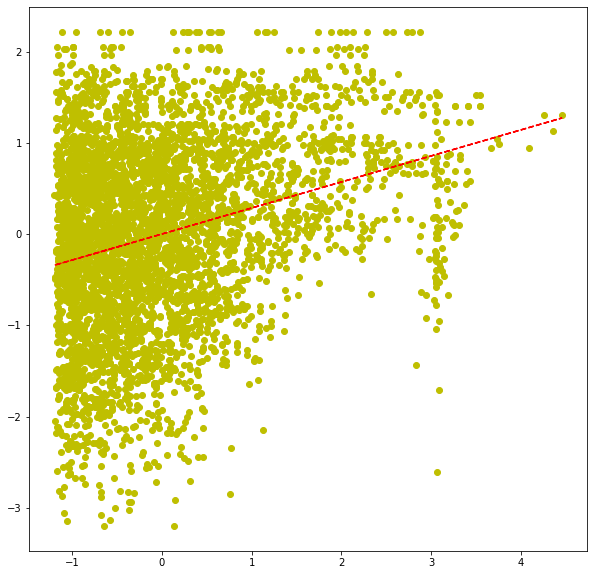

In [11]:
def plot_dist_correlation(dist1, dist2):
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca()
#     ax.scatter(dist_triu1, dist_triu2)
    fit = np.polyfit(dist1, dist2, 1)
    
    print('m={}, b={}'.format(fit[0], fit[1]))
    fit_fn = np.poly1d(fit) 
    
    ax.plot(dist1, dist2, 'yo', dist1, fit_fn(dist1), '--r')

plot_dist_correlation(zscore(pdist(nx_meas_mat_norm, 'euclidean')), zscore(pdist(adjacency_mat_sep_norm, 'euclidean')))

In [ ]:
df_nx_meas = pd.DataFrame(nx_meas_mat, columns=list(measurements_values.keys()), index=label_arr)
df_nx_meas.to_csv('/tmp/networkx_measures.csv')

df_adj_sep = pd.DataFrame(adjacency_mat_sep_norm, columns=label_arr.tolist()+label_arr.tolist(), index=label_arr)
df_adj_sep.to_csv('/tmp/adjacency_mat_sep_norm.csv')

df_adj_asym = pd.DataFrame(adjacency_mat_asym_norm, columns=label_arr.tolist(), index=label_arr)
df_adj_asym.to_csv('/tmp/adjacency_mat_asym_norm.csv')

df_adj_sym = pd.DataFrame(adjacency_mat_sym_norm, columns=label_arr.tolist(), index=label_arr)
df_adj_sym.to_csv('/tmp/adjacency_mat_sym_norm.csv')


m=-0.02153786680245981, b=0.4563731010725668


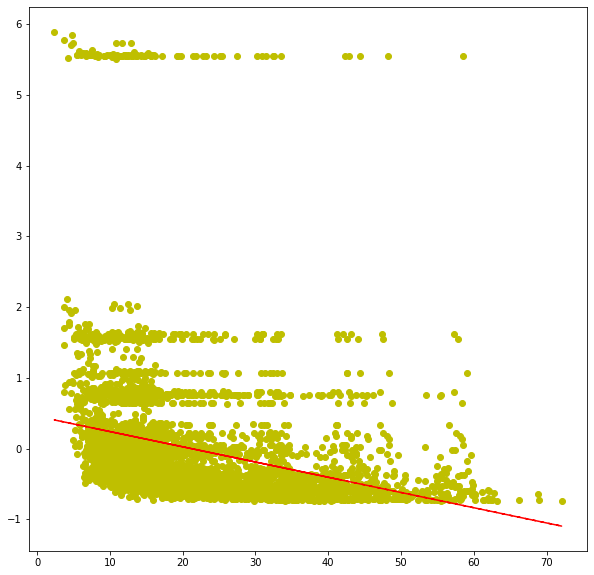

In [32]:
for ord_id in [24]:
    ordination = Ordination.objects.get(id=ord_id)
    bytes_path = ordination.dm.get_bytes_path()
    bytes_path = os.path.join(settings.BASE_DIR, bytes_path)

    sids_path = ordination.dm.get_sids_path()
    sids_path = os.path.join(settings.BASE_DIR, sids_path)
    sids = bytes_to_ndarray(sids_path, np.int32)
    metadata, headers = extract_tensor_metadata(sids, annotator)

    coordinates = get_rawdata_from_binary(bytes_path, len(sids))
    coordinates = drop_useless_columns(coordinates)
    coordinates = zscore(coordinates)
    coordinates[np.where(np.isinf(coordinates))] = 0
    coordinates[np.where(np.isnan(coordinates))] = 0

    dist_triu = pdist(coordinates, 'euclidean')
    distmat = triu2mat(dist_triu)
    nlabels = len(label_arr)
    distmat, classes_info = calc_class_dist_by_syl_features(syl_label_enum_arr, nlabels, coordinates, np.mean)
    dist_triu = mat2triu(distmat)

    plot_dist_correlation(dist_triu, zscore(pdist(adjacency_mat_asym, 'euclidean')))

#     print(classes_info)

m=0.01394550004232139, b=-0.2954958891098243


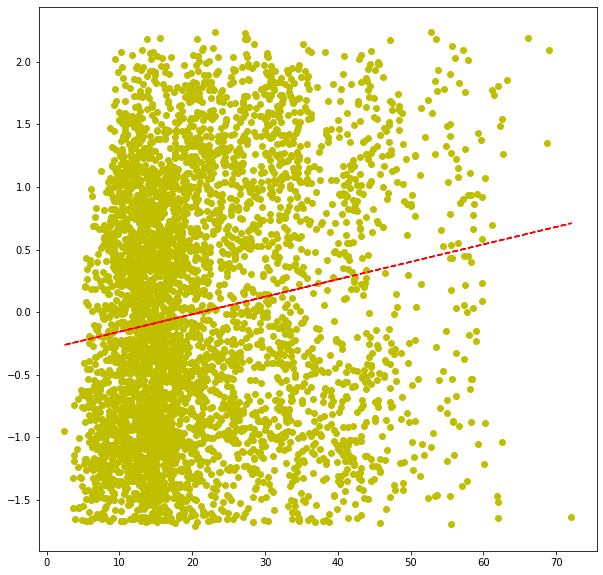

In [40]:
plot_dist_correlation(dist_triu, zscore(pdist(nx_meas_tsne, 'euclidean')))

In [ ]:
zscore(pdist(adjacency_mat_sym_norm, 'euclidean')).shape

In [ ]:
X1 = np.array([1,2,3,4,5])
X2 = np.array([2,3,4,5,6])
pdist(np.concatenate((X1, X2), axis=0))